In [9]:
%%capture
!pip install fastai==2.0.0
!pip install fastcore==1.0.0

## Setting workspace

In [2]:
import boto3
import os
import numpy as np
from pathlib import Path
from argparse import Namespace
from fastai.vision import *

args = Namespace(
    root = "/".join(os.getcwd().split("/")[:-1]),
    bucket_name = "sagemaker-us-west-2-430127992102",
    key = "ClassificationModel",
    image_dir = "fastai_data",
    data_dir = "dataset",
    tar_file_name = "dataset.tar.gz",
    model_dir = "model",
    tar_model_name = "model.tar.gz"
)
s3 = boto3.resource('s3')

## Download data from S3

In [14]:
s3.Bucket(args.bucket_name).download_file(Key = os.path.join(args.key, args.data_dir, args.tar_file_name),
                                         Filename = os.path.join(args.root, args.data_dir, args.tar_file_name))
tarfile.open(os.path.join(args.root, args.data_dir, args.tar_file_name), "r:gz").extractall(
    os.path.join(args.root, args.data_dir)
)

In [ ]:
os.remove(os.path.join(args.root, args.data_dir, args.tar_file_name))

## Loading data

In [11]:
model_path = os.path.join(args.root, args.model_dir)
data_path = Path(os.path.join(args.root, args.data_dir))
labels = os.listdir(data_path)

In [9]:
data = ImageDataLoaders.from_folder(data_path, valid_pct=0.2, bs=32, item_tfms=Resize(640), 
                    batch_tfms=[*aug_transforms(),Normalize.from_stats(*imagenet_stats)], num_workers=3)

NameError: name 'ImageDataLoaders' is not defined

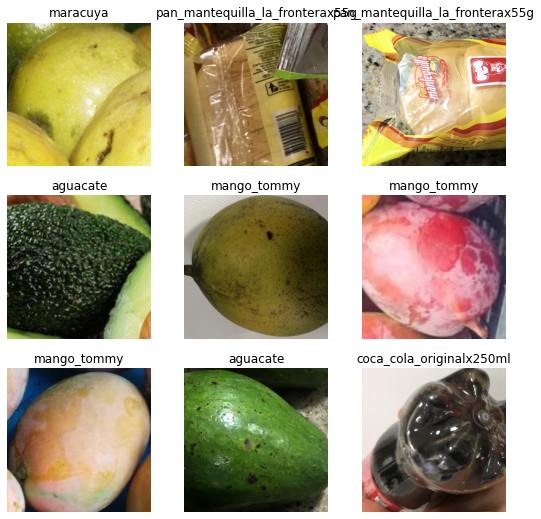

In [23]:
data.show_batch()

In [8]:
[class_name for class_name in data.vocab]

['aguacate',
 'arroz_basmati_castellanox1000g',
 'arroz_blanco_carullax1000g',
 'arroz_vitamor_dianax500g',
 'chicharron_americano_jacksx15g',
 'coca_cola_originalx250ml',
 'coca_cola_originalx400ml',
 'mango_tommy',
 'maracuya',
 'pan_de_queso_la_frontera',
 'pan_mantequilla_la_fronterax55g',
 'papas_limon_margarita_packeconomicox300g',
 'papas_limon_margaritax105g',
 'papas_limon_margaritax110g',
 'papas_limon_margaritax39g',
 'spagheti_barilla',
 'yogurt_alpina_finesse_fresax150g',
 'yogurt_alpina_finesse_fresax180g',
 'yogurt_alpina_finesse_frutos_rojosx180g',
 'yogurt_alpina_finesse_melocotonx180g']

## Training pretrained model

In [60]:
learn = cnn_learner(data, resnet34, metrics=[error_rate,accuracy])

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0030199517495930195)

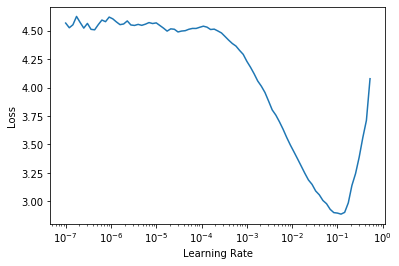

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(3,lr=6e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.329937,0.392673,0.128332,0.871668,02:10
1,0.599325,0.267307,0.099704,0.900296,02:08
2,0.399772,0.224018,0.081935,0.918065,02:10


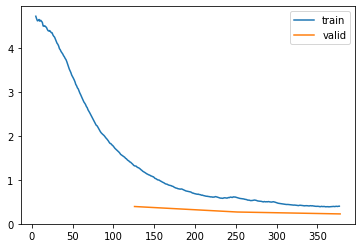

In [63]:
learn.recorder.plot_loss()

In [64]:
learn.save(os.path.join(model_path,'stage-1'))

In [90]:
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=1.3182567499825382e-06)

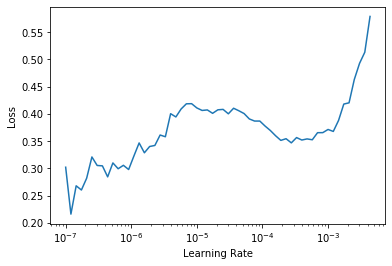

In [91]:
learn.lr_find()

In [92]:
learn.fit_one_cycle(100,lr=1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.540667,0.784894,0.195459,0.804541,02:14
1,0.835209,0.907412,0.255676,0.744324,02:13
2,0.711716,0.699136,0.199408,0.800592,02:12
3,0.652723,0.676272,0.217177,0.782823,02:13
4,0.535761,0.560638,0.169793,0.830207,02:14
5,0.462294,0.320766,0.122409,0.877591,02:12
6,0.358266,0.230104,0.076999,0.923001,02:13
7,0.234502,0.158761,0.060217,0.939783,02:13
8,0.181597,0.147556,0.057256,0.942744,02:12
9,0.159508,0.139820,0.050346,0.949655,02:13


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f443a5e30b8>>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f443a5e30b8>>
Traceback (most recent call last):
  File "/home/ec2-user

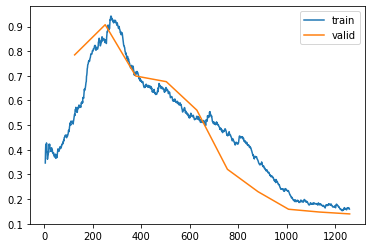

In [93]:
learn.recorder.plot_loss()

In [94]:
learn.save(os.path.join(model_path, 'stage-2'))

In [7]:
!pwd

/Users/cvillad/documents/classification_model/src


In [8]:
learn = load_learner('../model/export.pkl')

## Interpretation

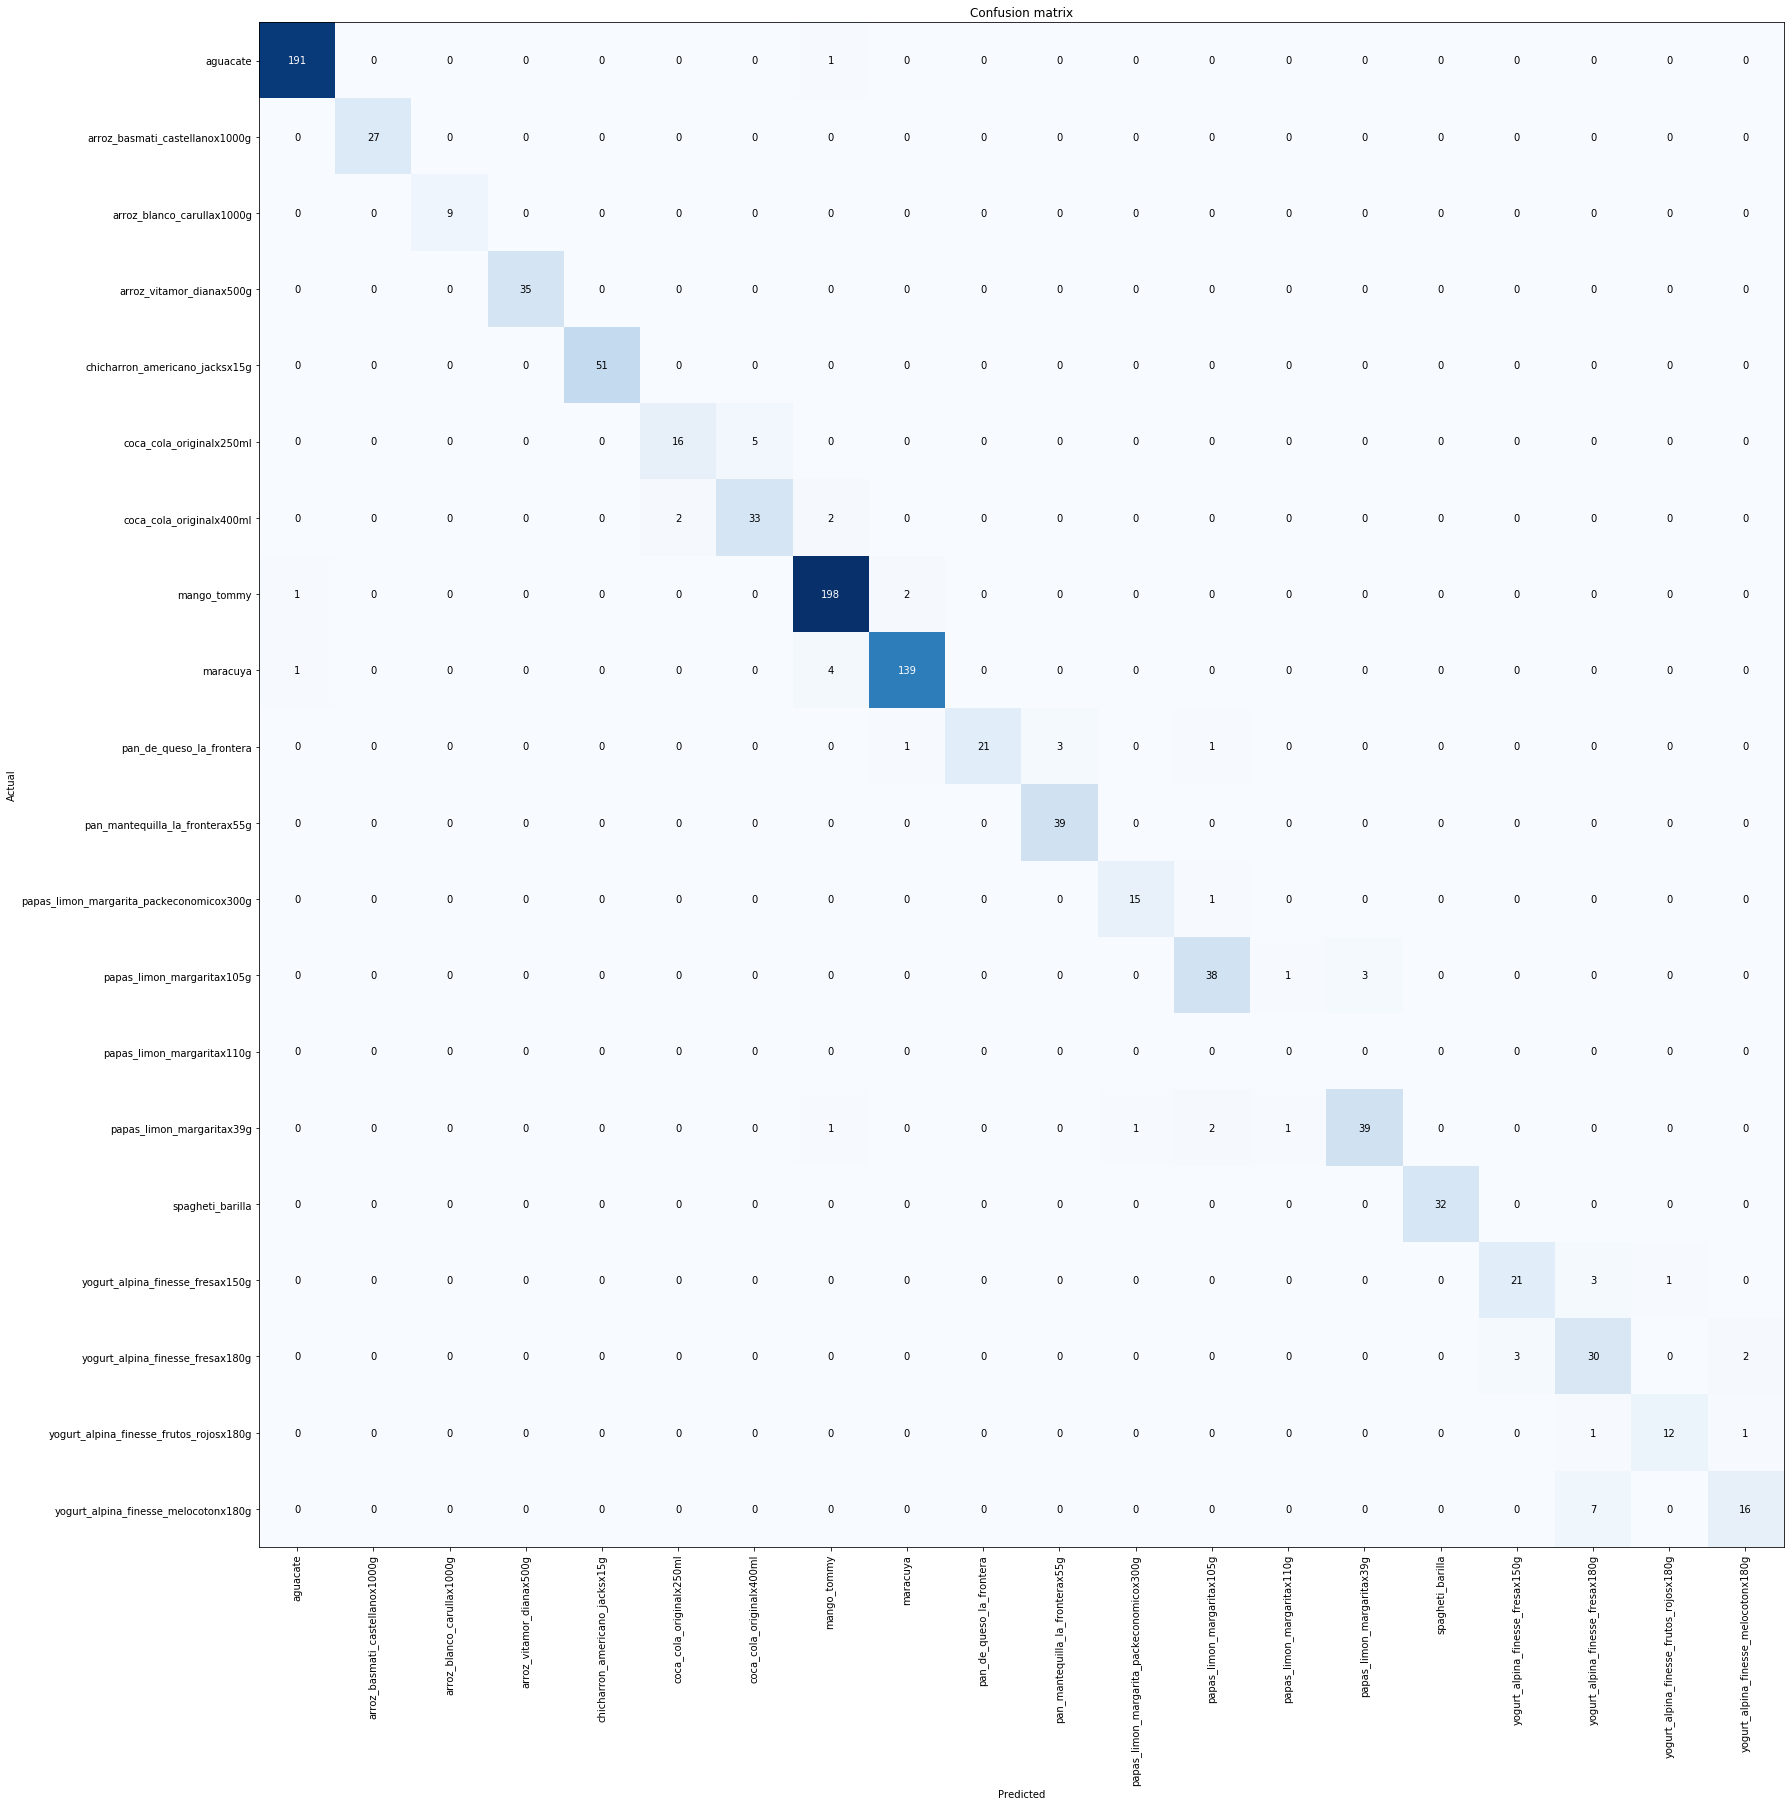

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,25))

In [26]:
!pwd

/Users/cvillad/documents/classification_model/src


In [27]:
learn = load_learner(os.path.join('../model', 'export_2.pkl'))

## Prediction

maracuya 0.9889556765556335
tensor(8)


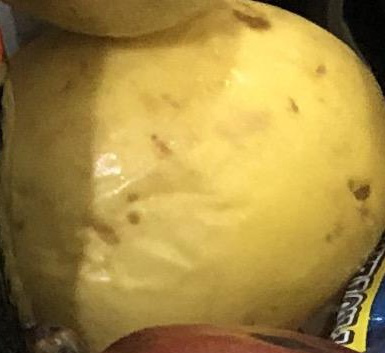

In [10]:
import json
from PIL import Image
#!curl "https://jumbocolombiafood.vteximg.com.br/arquivos/ids/3496861-750-750/7702001041701.jpg?v=637230819964000000" --output test.jpg
img_path = '../test2.jpg'
img = open_image(img_path)
img
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class, outputs[pred_idx].item())
print(pred_idx)
img
#!rm test.jpg

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from fastai.vision import open_image, image
cap = cv2.VideoCapture(0)

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,200)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2
    
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if frame is None:
        break
    print(frame)
    print(frame.shape)
    x = np2model_tensor(np.transpose(frame, (2, 0, 1)))
    img = image.Image(x.true_divide(255))
    # pass to the model
    pred_class, pred_idx, outputs = learn.predict(img)
    
    
    cv2.putText(frame, f'{pred_class.obj}', 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    # Display the resulting frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

[[[205 199 247]
  [212 206 254]
  [237 241 241]
  [243 247 247]
  ...
  [ 27  34  42]
  [ 20  27  35]
  [ 28  28  28]
  [ 27  27  27]]

 [[198 192 218]
  [205 199 225]
  [226 226 226]
  [236 236 236]
  ...
  [ 21  32  43]
  [ 16  28  38]
  [ 28  29  24]
  [ 28  29  24]]

 [[197 184 201]
  [198 185 202]
  [202 194 209]
  [207 199 213]
  ...
  [ 20  31  42]
  [ 16  28  38]
  [ 28  28  26]
  [ 26  26  24]]

 [[204 186 204]
  [201 184 201]
  [197 184 203]
  [199 186 205]
  ...
  [ 28  30  42]
  [ 27  29  40]
  [ 28  27  30]
  [ 26  25  27]]

 ...

 [[  2  16  17]
  [  1  15  16]
  [ 13  12  16]
  [ 13  12  16]
  ...
  [  3  15  14]
  [  3  15  14]
  [  7  17  13]
  [  6  15  12]]

 [[  3  13  19]
  [  3  13  19]
  [ 11  11  18]
  [ 10  10  17]
  ...
  [  2  17  13]
  [  1  16  12]
  [  6  16  10]
  [  7  17  12]]

 [[  5  13  26]
  [  3  12  25]
  [  8  12  21]
  [  6  11  20]
  ...
  [  0  18  12]
  [  0  17  10]
  [  7  18  10]
  [  8  19  11]]

 [[  2  13  28]
  [  2  13  28]
  [  3  13

[[[202 201 224]
  [218 218 240]
  [240 241 248]
  [244 244 251]
  ...
  [ 26  24  41]
  [ 26  24  41]
  [ 36  35  51]
  [ 34  33  49]]

 [[203 198 217]
  [205 201 219]
  [217 215 222]
  [226 224 231]
  ...
  [ 29  28  44]
  [ 25  23  39]
  [ 30  30  42]
  [ 36  36  47]]

 [[192 179 197]
  [195 182 199]
  [198 190 198]
  [205 197 205]
  ...
  [ 28  27  43]
  [ 25  23  39]
  [ 33  34  40]
  [ 34  35  41]]

 [[206 187 200]
  [206 187 200]
  [200 184 195]
  [201 185 196]
  ...
  [ 29  28  42]
  [ 28  27  41]
  [ 37  38  45]
  [ 33  34  40]]

 ...

 [[ 11   8   3]
  [ 14  10   6]
  [ 14  14  14]
  [ 15  15  15]
  ...
  [ 12  13  18]
  [ 12  13  18]
  [ 14  14  14]
  [ 13  13  13]]

 [[ 14  11  12]
  [ 14  11  12]
  [ 12  12  10]
  [ 13  13  11]
  ...
  [ 14  13  18]
  [ 14  13  18]
  [ 13  13  13]
  [ 12  12  12]]

 [[ 14  13  18]
  [ 14  13  18]
  [  9  13  13]
  [  6  11  10]
  ...
  [ 13  12  16]
  [ 14  13  18]
  [ 13  13  13]
  [ 10  10  10]]

 [[  8   8  19]
  [ 12  12  23]
  [  8  15

[[[204 200 228]
  [217 213 240]
  [240 240 249]
  [241 241 251]
  ...
  [ 23  36  40]
  [ 27  40  43]
  [ 21  43  46]
  [ 20  42  44]]

 [[199 195 212]
  [201 198 214]
  [219 220 225]
  [230 231 235]
  ...
  [ 24  34  40]
  [ 28  38  44]
  [ 26  41  46]
  [ 24  38  44]]

 [[187 185 195]
  [186 184 193]
  [195 193 195]
  [200 197 200]
  ...
  [ 28  35  41]
  [ 29  37  43]
  [ 29  40  43]
  [ 27  37  41]]

 [[191 187 204]
  [192 188 205]
  [197 186 196]
  [195 183 193]
  ...
  [ 29  37  41]
  [ 27  35  39]
  [ 31  35  37]
  [ 31  35  37]]

 ...

 [[  1  16  12]
  [  4  18  15]
  [ 11  19  14]
  [ 11  19  14]
  ...
  [  8  14  18]
  [ 10  16  20]
  [ 10  15  23]
  [  9  14  22]]

 [[  4  14  11]
  [  7  17  13]
  [ 14  20  15]
  [ 13  19  14]
  ...
  [ 10  14  14]
  [  9  13  13]
  [  7  11  17]
  [  7  11  17]]

 [[ 11  13  13]
  [ 12  14  14]
  [ 14  17  15]
  [ 13  16  13]
  ...
  [ 10  14  16]
  [  7  12  13]
  [  9   8  15]
  [  9   8  15]]

 [[ 13  12  15]
  [ 14  13  16]
  [ 12  14

[[[210 206 222]
  [222 219 235]
  [245 238 248]
  [251 244 254]
  ...
  [ 45  29  29]
  [ 45  29  29]
  [ 31  29  39]
  [ 26  24  33]]

 [[204 200 216]
  [208 205 221]
  [223 216 228]
  [231 224 236]
  ...
  [ 40  28  31]
  [ 44  32  36]
  [ 27  30  39]
  [ 31  33  42]]

 [[188 180 197]
  [195 187 204]
  [202 194 211]
  [207 198 215]
  ...
  [ 36  29  37]
  [ 39  33  40]
  [ 24  34  42]
  [ 29  39  47]]

 [[202 188 209]
  [202 188 209]
  [198 187 208]
  [197 186 207]
  ...
  [ 31  27  35]
  [ 43  39  46]
  [ 24  33  44]
  [ 31  40  51]]

 ...

 [[  1   8   5]
  [  0   5   2]
  [  0   4   1]
  [  0   4   1]
  ...
  [  9  16  13]
  [  9  16  13]
  [ 12  15  12]
  [ 11  14  11]]

 [[  0   6   0]
  [  0   4   0]
  [  0   2   0]
  [  0   4   0]
  ...
  [  8  15  14]
  [  8  15  14]
  [ 12  12  12]
  [ 12  12  12]]

 [[  0   4   0]
  [  0   3   0]
  [  0   1   0]
  [  4   5   0]
  ...
  [ 11  15  17]
  [  9  13  15]
  [ 13  10  10]
  [ 13  10  10]]

 [[  0   5   0]
  [  0   4   0]
  [  2   3

[[[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 57  55  62]
  [ 63  61  68]
  [ 50  61  62]
  [ 51  62  64]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 65  59  64]
  [ 61  56  61]
  [ 58  60  62]
  [ 61  63  65]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 61  57  57]
  [ 60  55  56]
  [ 60  57  60]
  [ 62  59  61]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 54  54  52]
  [ 56  56  54]
  [ 58  55  58]
  [ 58  55  58]]

 ...

 [[ 18  19  33]
  [ 24  25  39]
  [ 20  25  41]
  [ 27  32  48]
  ...
  [ 28  25  26]
  [ 37  35  35]
  [ 19  32  22]
  [ 20  33  23]]

 [[ 12  21  13]
  [ 15  23  16]
  [ 19  27  24]
  [ 26  34  31]
  ...
  [ 22  23  20]
  [ 33  33  31]
  [ 20  33  23]
  [ 17  31  21]]

 [[ 19  37   6]
  [ 12  30   0]
  [ 19  27   1]
  [ 20  28   2]
  ...
  [ 22  22  22]
  [ 28  28  28]
  [ 24  35  27]
  [ 21  32  24]]

 [[ 12  32   5]
  [ 14  34   7]
  [ 26  30

[[[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 49  45  63]
  [ 44  40  59]
  [ 53  43  57]
  [ 58  47  62]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 47  53  70]
  [ 44  49  67]
  [ 49  47  54]
  [ 47  45  52]]

 [[227 227 227]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 41  53  72]
  [ 41  53  72]
  [ 43  49  51]
  [ 34  41  43]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 44  58  59]
  [ 47  60  61]
  [ 49  58  57]
  [ 47  57  56]]

 ...

 [[ 19  24  23]
  [ 18  23  22]
  [ 15  27  24]
  [ 17  30  26]
  ...
  [ 33  23  15]
  [ 32  22  14]
  [ 30  21  29]
  [ 33  25  32]]

 [[ 16  23  22]
  [ 15  22  21]
  [ 14  29  25]
  [ 18  32  29]
  ...
  [ 27  22  16]
  [ 30  24  18]
  [ 30  22  27]
  [ 28  20  26]]

 [[ 20  24  28]
  [ 19  23  27]
  [ 15  29  28]
  [ 19  33  31]
  ...
  [ 18  24  17]
  [ 17  23  16]
  [ 29  20  23]
  [ 31  21  24]]

 [[ 27  25  32]
  [ 22  21  28]
  [ 16  27

[[[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 58  55  58]
  [ 51  48  51]
  [ 47  48  53]
  [ 51  53  57]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 52  54  63]
  [ 47  50  58]
  [ 47  49  49]
  [ 46  48  48]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 47  56  64]
  [ 47  56  64]
  [ 52  56  56]
  [ 47  52  51]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 52  62  49]
  [ 50  59  47]
  [ 42  58  48]
  [ 42  58  48]]

 ...

 [[ 15  20   9]
  [ 18  23  11]
  [ 29  23  26]
  [ 32  27  30]
  ...
  [ 29  32  31]
  [ 29  32  31]
  [ 39  27  23]
  [ 35  22  19]]

 [[ 17  21  11]
  [ 19  23  14]
  [ 28  26  24]
  [ 30  28  26]
  ...
  [ 23  33  39]
  [ 21  31  37]
  [ 34  29  21]
  [ 31  26  17]]

 [[ 22  25  13]
  [ 23  26  14]
  [ 24  27  17]
  [ 23  25  16]
  ...
  [ 12  14  25]
  [ 10  12  23]
  [ 13  15   6]
  [ 14  16   7]]

 [[ 21  23  16]
  [ 22  24  17]
  [ 22  23

[[[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 51  53  64]
  [ 52  54  65]
  [ 49  48  64]
  [ 47  45  61]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 53  53  62]
  [ 54  54  63]
  [ 50  50  61]
  [ 47  46  58]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 52  51  58]
  [ 56  54  61]
  [ 53  54  58]
  [ 49  50  55]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 56  51  61]
  [ 58  54  63]
  [ 54  56  58]
  [ 51  53  55]]

 ...

 [[ 24  21  26]
  [ 23  20  25]
  [ 34  18  26]
  [ 35  19  28]
  ...
  [ 21  23  16]
  [ 23  25  18]
  [ 19  24  23]
  [ 19  24  23]]

 [[ 21  21  21]
  [ 17  17  17]
  [ 27  15  18]
  [ 32  19  23]
  ...
  [ 21  22  17]
  [ 23  24  20]
  [ 19  20  26]
  [ 19  20  26]]

 [[ 18  20  20]
  [ 17  19  19]
  [ 23  15  18]
  [ 25  17  20]
  ...
  [ 19  20  25]
  [ 21  22  27]
  [ 19  20  36]
  [ 17  18  34]]

 [[ 13  17  19]
  [ 14  19  20]
  [ 23  17

[[[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 51  57  59]
  [ 54  61  62]
  [ 51  57  59]
  [ 44  50  52]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 51  54  58]
  [ 52  55  60]
  [ 50  56  58]
  [ 50  56  58]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 49  51  51]
  [ 49  51  51]
  [ 48  54  49]
  [ 48  54  49]]

 [[228 228 228]
  [228 228 228]
  [228 228 228]
  [228 228 228]
  ...
  [ 50  52  45]
  [ 49  51  44]
  [ 44  51  34]
  [ 42  48  32]]

 ...

 [[ 24  24  31]
  [ 20  21  28]
  [ 30  23  33]
  [ 36  29  39]
  ...
  [ 22  25  11]
  [ 23  26  13]
  [ 22  25  13]
  [ 22  25  13]]

 [[ 14  19  20]
  [ 16  20  22]
  [ 31  21  24]
  [ 35  25  29]
  ...
  [ 21  24  12]
  [ 21  24  12]
  [ 21  23  14]
  [ 23  25  16]]

 [[ 13  18  16]
  [ 17  22  19]
  [ 30  20  16]
  [ 27  16  13]
  ...
  [ 20  23   9]
  [ 21  24  10]
  [ 21  24  12]
  [ 21  24  12]]

 [[ 13  17   8]
  [ 15  20  10]
  [ 29  23

[[[229 230 228]
  [229 230 228]
  [228 229 226]
  [228 229 226]
  ...
  [ 63  47  46]
  [ 61  46  45]
  [ 52  52  52]
  [ 56  56  56]]

 [[227 228 225]
  [227 228 225]
  [228 229 226]
  [228 229 226]
  ...
  [ 69  55  56]
  [ 62  48  49]
  [ 47  52  51]
  [ 40  45  44]]

 [[226 226 224]
  [226 226 224]
  [227 228 225]
  [228 229 226]
  ...
  [ 56  46  50]
  [ 61  51  54]
  [ 40  47  48]
  [ 37  43  45]]

 [[226 226 224]
  [226 226 224]
  [227 228 225]
  [227 228 225]
  ...
  [ 52  49  54]
  [ 52  49  54]
  [ 49  47  54]
  [ 49  47  54]]

 ...

 [[112 132 116]
  [111 130 115]
  [122 129 115]
  [116 124 109]
  ...
  [ 22  23  30]
  [ 26  27  33]
  [ 23  19  26]
  [ 21  17  24]]

 [[110 128 119]
  [110 128 119]
  [121 130 120]
  [116 125 115]
  ...
  [ 19  26  27]
  [ 22  28  30]
  [ 24  26  21]
  [ 22  23  19]]

 [[109 125 123]
  [107 124 122]
  [113 126 118]
  [113 126 118]
  ...
  [ 20  27  27]
  [ 19  26  26]
  [ 24  30  13]
  [ 24  30  13]]

 [[110 126 125]
  [107 124 122]
  [105 123

[[[229 230 226]
  [228 229 225]
  [226 227 222]
  [227 228 223]
  ...
  [ 41  40  43]
  [ 54  53  55]
  [ 71  48  60]
  [ 74  51  62]]

 [[226 226 224]
  [228 229 226]
  [229 230 228]
  [229 230 228]
  ...
  [ 43  46  44]
  [ 50  53  51]
  [ 59  42  48]
  [ 60  43  49]]

 [[222 223 221]
  [225 225 223]
  [226 226 224]
  [226 226 224]
  ...
  [ 45  51  42]
  [ 47  54  44]
  [ 50  37  35]
  [ 52  39  38]]

 [[225 225 225]
  [221 221 221]
  [220 220 220]
  [220 220 220]
  ...
  [ 45  53  36]
  [ 44  52  35]
  [ 50  38  30]
  [ 55  43  35]]

 ...

 [[ 21  18  30]
  [ 21  18  30]
  [ 21  21  21]
  [ 20  20  20]
  ...
  [ 22  25  24]
  [ 21  24  23]
  [ 20  23  20]
  [ 20  23  20]]

 [[ 21  18  30]
  [ 17  15  26]
  [ 15  16  13]
  [ 16  17  15]
  ...
  [ 22  25  24]
  [ 20  22  22]
  [ 19  22  17]
  [ 17  20  15]]

 [[ 20  22  24]
  [ 18  19  22]
  [ 15  16  13]
  [ 15  16  13]
  ...
  [ 21  22  27]
  [ 19  20  25]
  [ 16  21  18]
  [ 13  18  16]]

 [[ 14  20  17]
  [ 16  21  18]
  [ 15  18

## Uploading model to s3

In [1]:
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
    return output_filename

In [7]:
args.output_filename = make_tarfile(os.path.join(args.root, args.model_dir, 'stage-2.pth'), 
                                             os.path.join(args.root, args.model_dir))
s3.meta.client.upload_file(args.output_filename, Bucket=args.bucket_name, Key=os.path.join(args.key,
                                                                                         args.model_dir,
                                                                                         args.tar_model_name))
os.remove(args.output_filename)

In [4]:
learn = load_learner('../model', 'export_student.pkl')